In [1]:
#!pip install qiskit
#!pip install qiskit_optimization
#!pip install qiskit_machine_learning
#!pip install pylatexenc
#!pip install qiskit_ibm_runtime
#!pip install qiskit-aer
#!pip install matplotlib
#!pip install qiskit_algorithms

In [5]:
import numpy as np
import tensorflow as tf


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y_ = np.where(y == 3, -1, 1)
    return x,y_,y

In [7]:
x_train, y_train, y_temp = filter_36(x_train, y_train)
x_test, y_test, y_temp = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [8]:
y_test

array([ 1, -1,  1, ...,  1, -1,  1])

In [9]:
y_temp

array([6, 3, 6, ..., 6, 3, 6], dtype=uint8)

In [10]:
n_qubits = 3  # Number of qubits

latent_dim = 2 ** n_qubits    # Selected latent dimensions

reduced_classes = [3,6] # Selected (and sorted) classes

# Number of reduced classes
reduced_num_classes = len(reduced_classes)

In [11]:
X_ends_pre1 = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_tests_pre1 = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print(X_ends_pre1.shape)
print(X_tests_pre1.shape)

(12049, 784)
(1968, 784)


In [12]:
# initializing the pca
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=latent_dim)
pca.fit(X_ends_pre1)

print(f'Total number of components used after PCA : {pca.n_components_}')

Total number of components used after PCA : 8


In [14]:
train_img = pca.transform(X_ends_pre1)
test_img = pca.transform(X_tests_pre1)

print(f'train_img shape : {train_img.shape}')
print(f'test_img shape : {test_img.shape}')

train_img shape : (12049, 8)
test_img shape : (1968, 8)


In [15]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = 'lbfgs')
clf.fit(train_img, y_train)

MLPClassifier(solver='lbfgs')

In [16]:
Y_ends_pre = y_train
Y_tests_pre = y_test

In [17]:
print('Training score : ', clf.score(train_img, Y_ends_pre))
print('Testing score  : ', clf.score(test_img, Y_tests_pre))

Training score :  1.0
Testing score  :  0.9949186991869918


In [18]:
# Encode data with our new autoencoder
QX_train = train_img
QX_test = test_img

**QCNN**

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import qiskit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import *
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SPSA, NFT
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeAuckland, FakeWashington, FakeLagosV2, FakeMumbaiV2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import time

from qiskit.providers.fake_provider import GenericBackendV2

algorithm_globals.random_seed = 12345

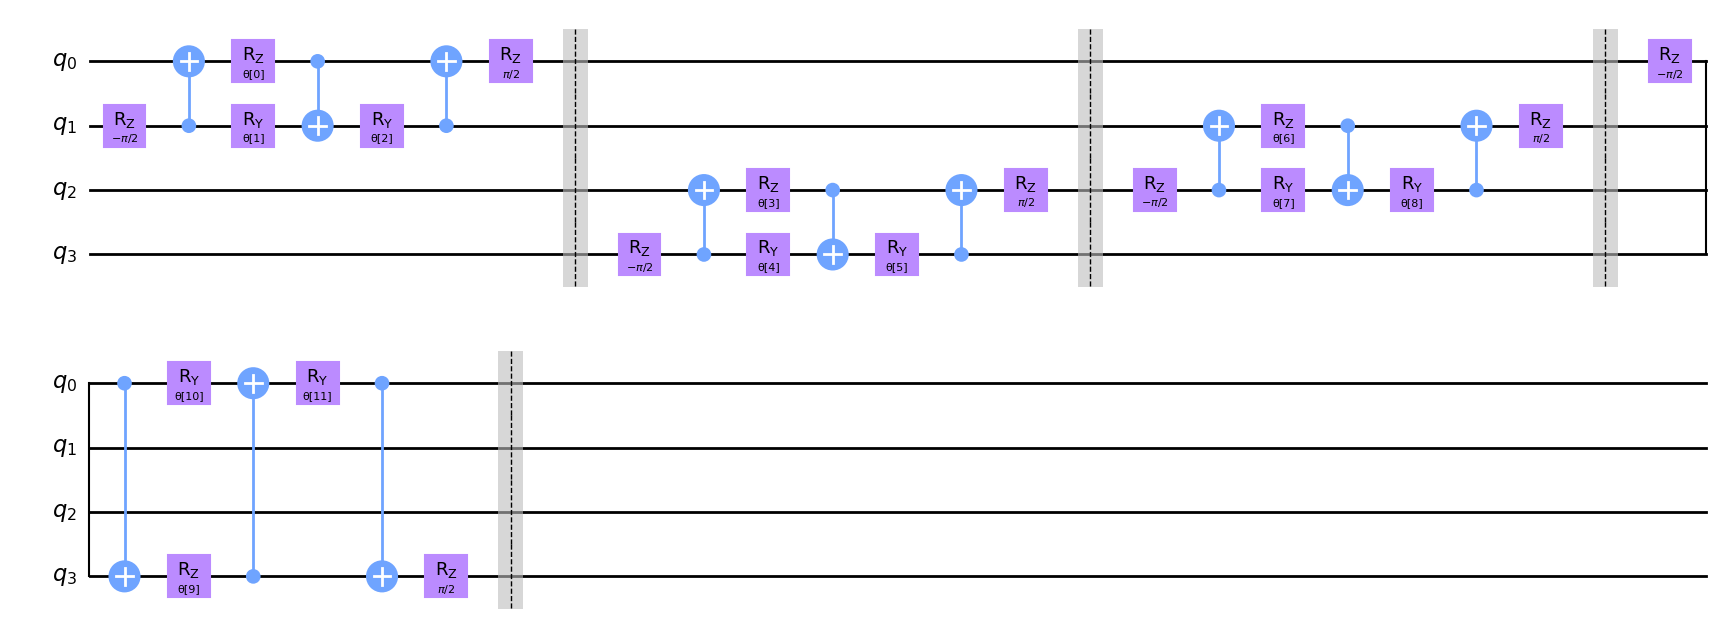

In [20]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

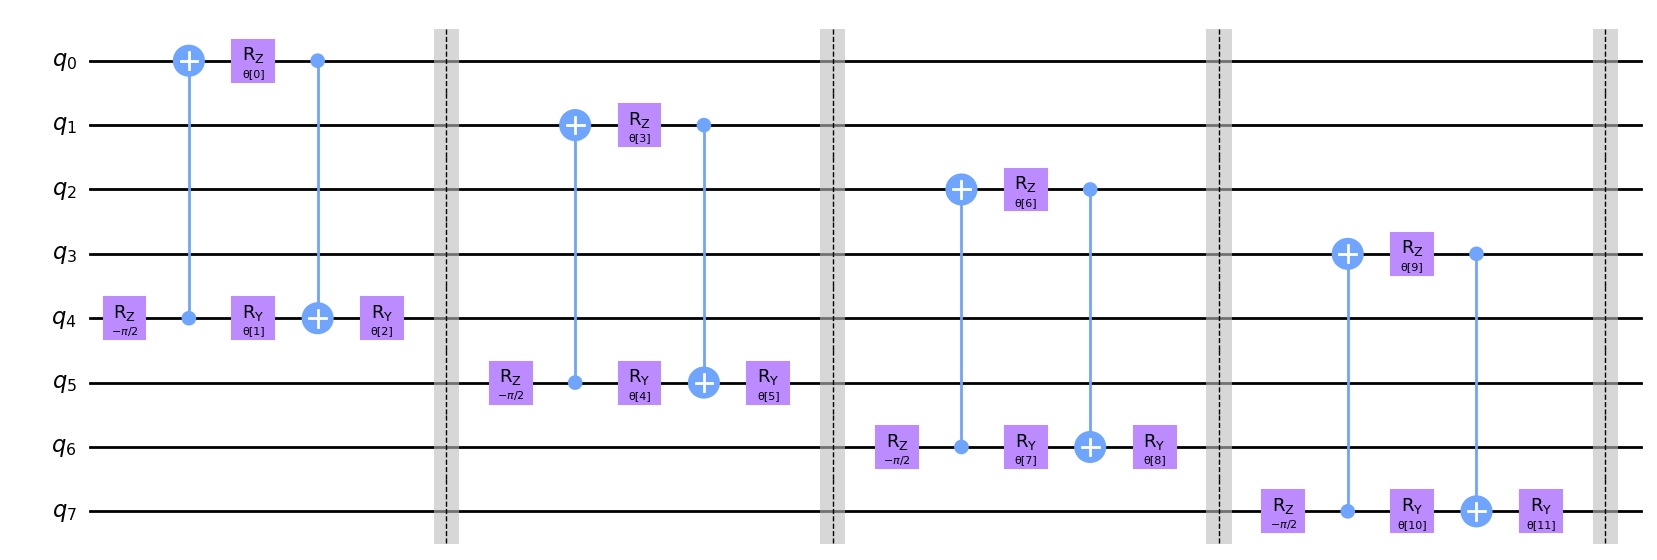

In [21]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1, 2, 3]
sinks = [4, 5, 6, 7]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [22]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [23]:
latent_dim

8

In [24]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

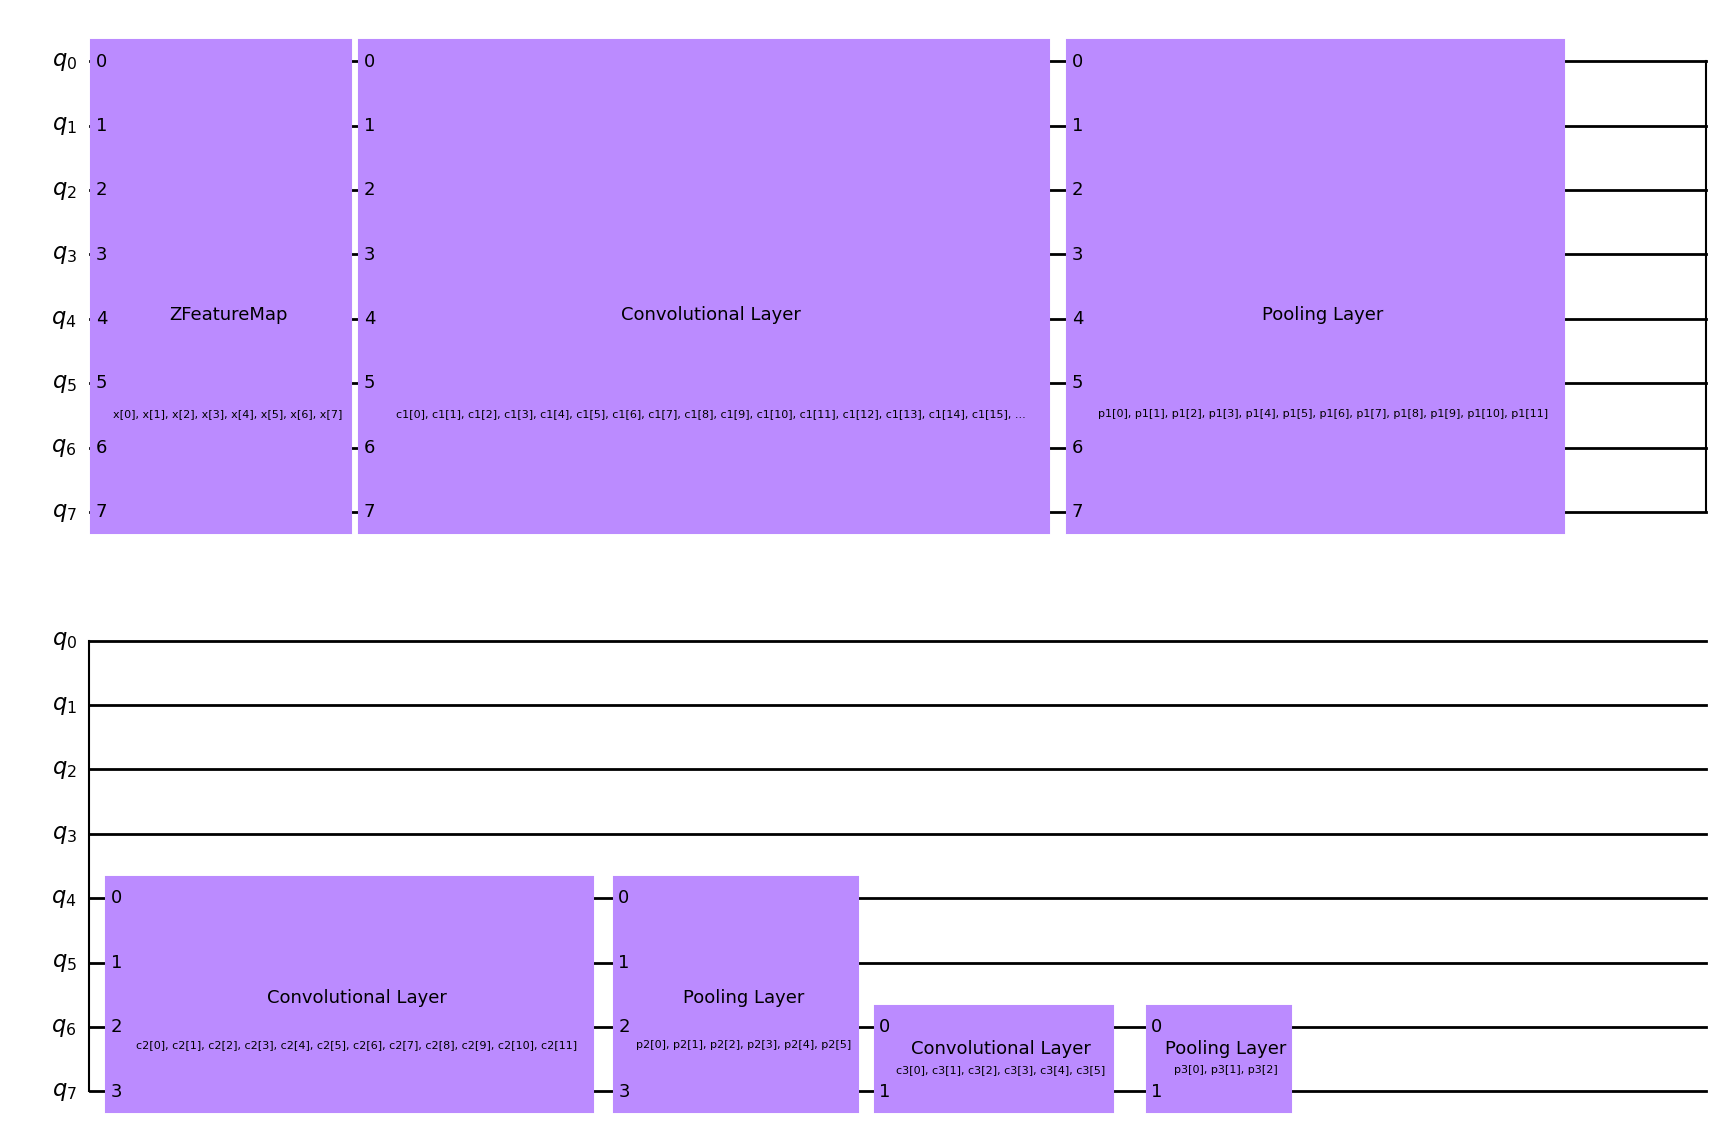

In [25]:
circuit.draw("mpl", style="clifford")

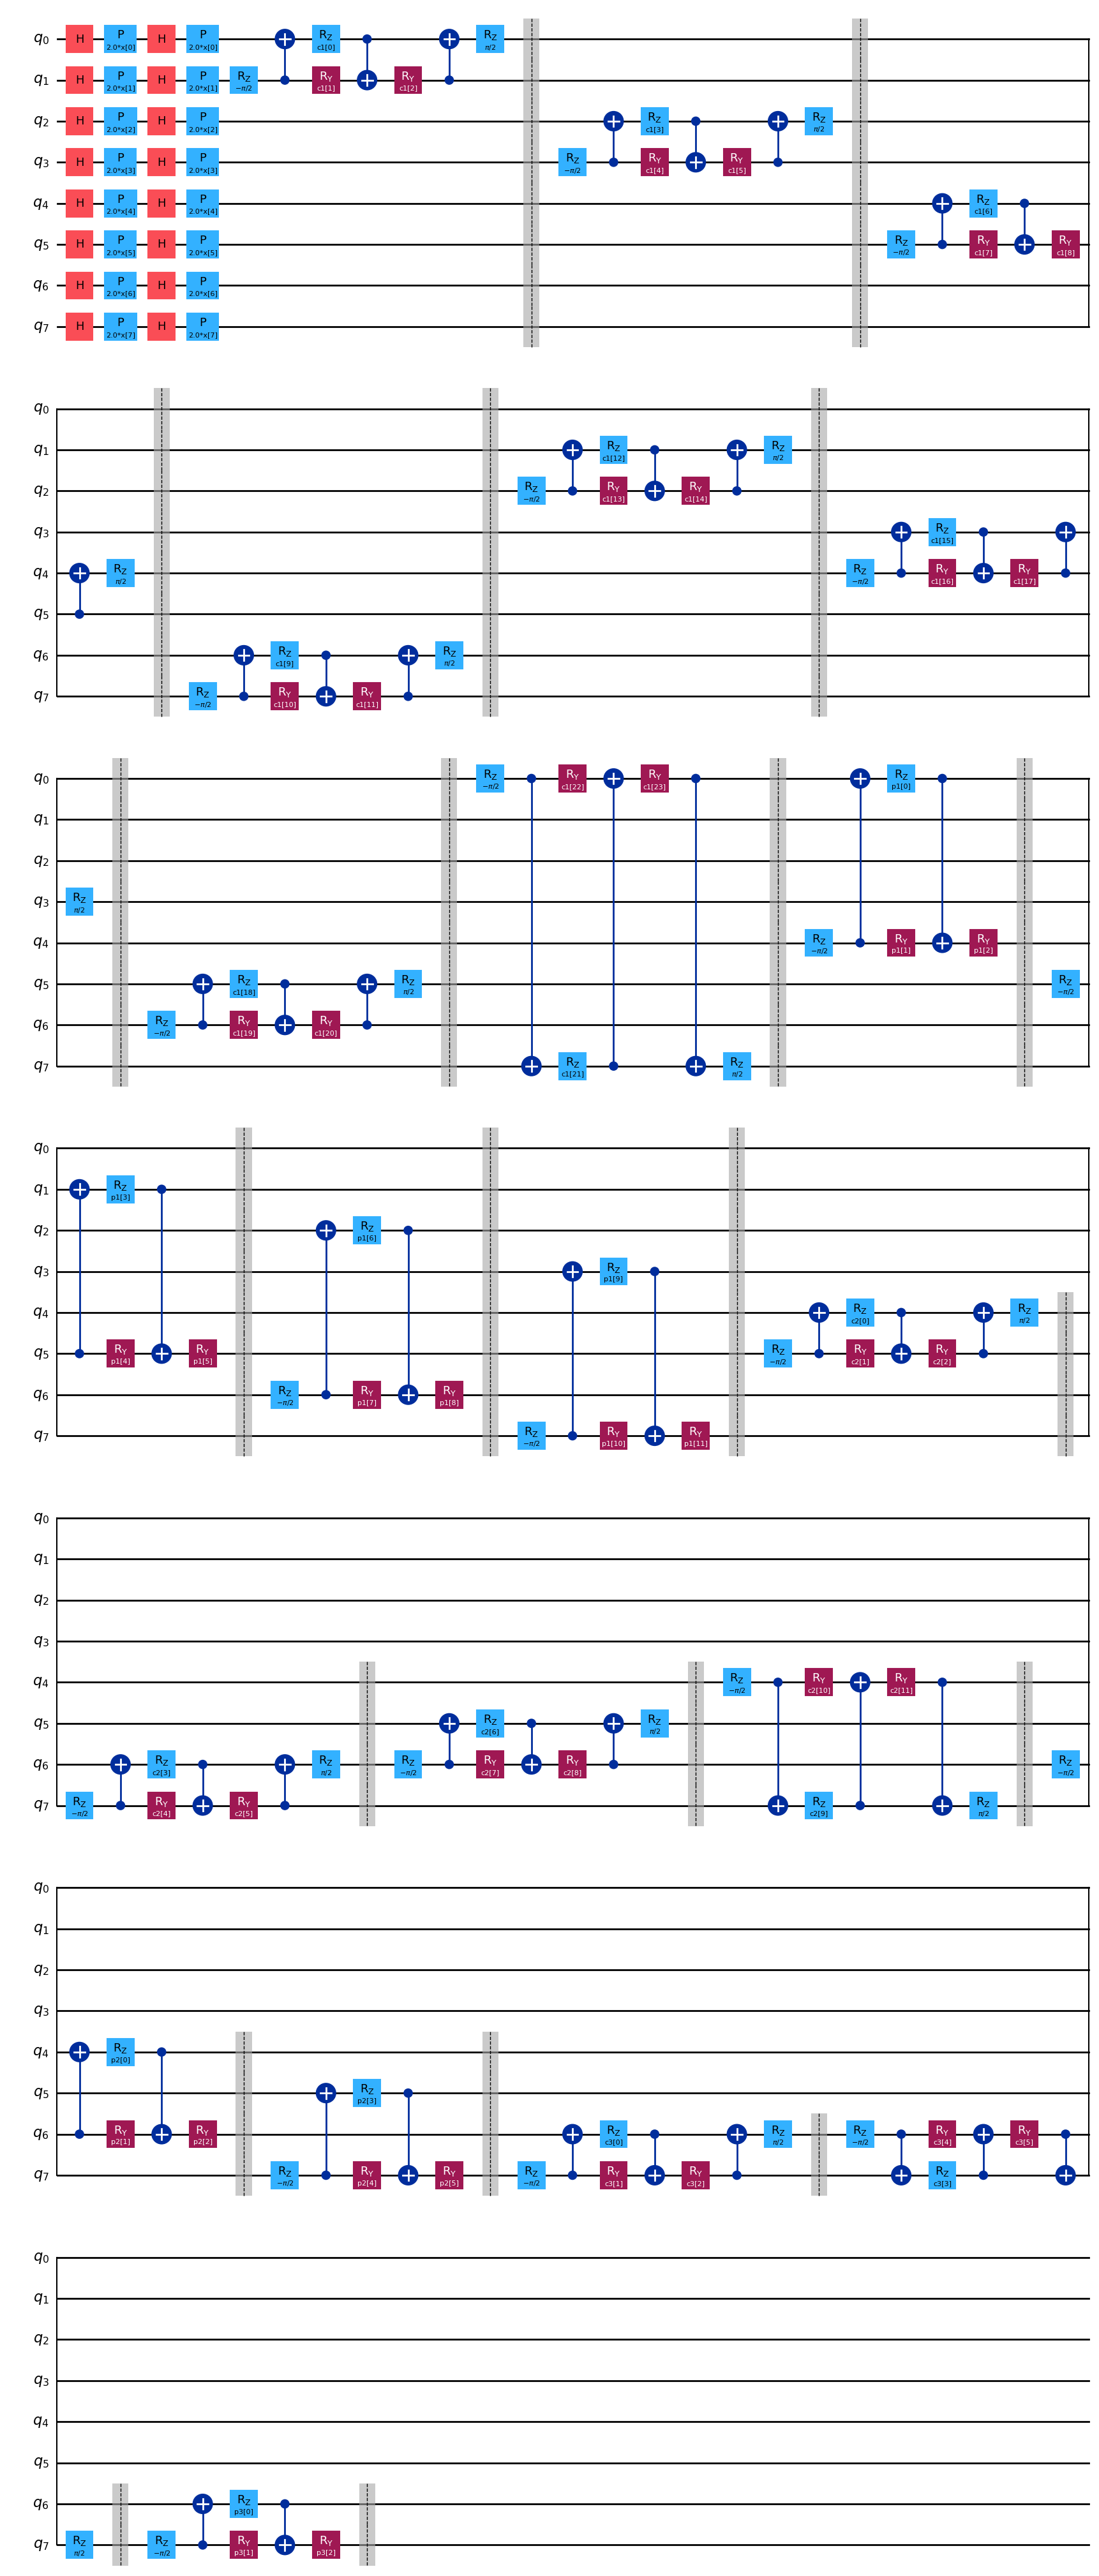

In [26]:
#backend = GenericBackendV2(num_qubits=latent_dim)
backend = AerSimulator()

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial", # Fixed layout mapped in circuit order
)

transpiled_circ1 = pass_manager.run(circuit)

# View the transpiled circuit
transpiled_circ1.draw(output='mpl', idle_wires=False)

In [27]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [28]:
n_sample = 3000
x = np.asarray(QX_train)[:n_sample]
y = np.asarray(Y_ends_pre)[:n_sample]

In [29]:
# x = np.asarray(QX_train)
# y = np.asarray(Y_ends_pre)

In [30]:
x_test1 = np.asarray(QX_test)[:n_sample]
y_test1 = np.asarray(Y_tests_pre)[:n_sample]

In [31]:
classifier7 = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=30),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

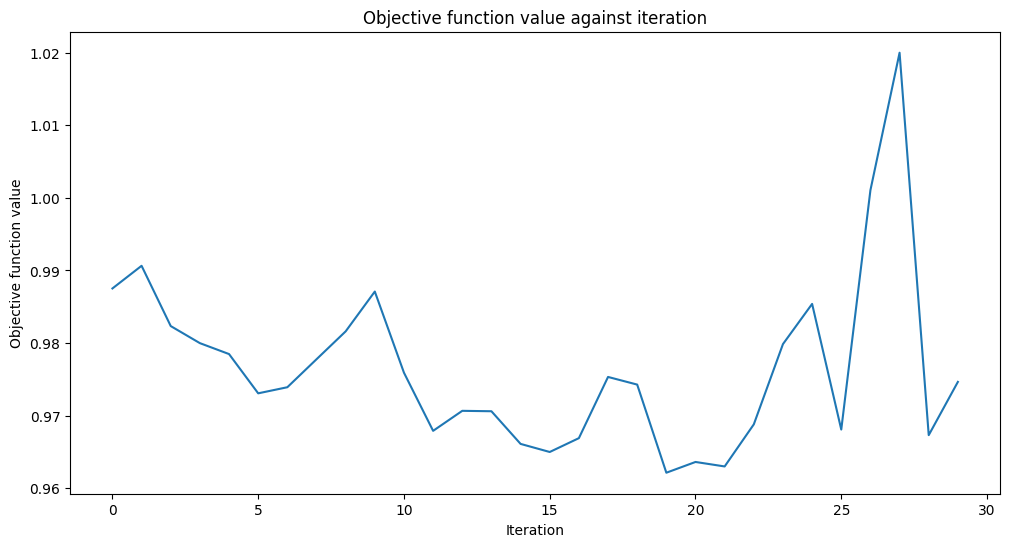

Accuracy from the train data 7 : 58.33%


In [32]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier7.fit(x, y)

# score classifier
print(f"Accuracy from the train data 7 : {np.round(100 * classifier7.score(x, y), 2)}%")

In [54]:
y_predict7 = classifier7.predict(x_test1)
print(f"Accuracy from the test data 7 : {np.round(100 * classifier7.score(x_test1, y_test1), 2)}%")

Accuracy from the test data 7 : 55.89%


In [36]:
print("Precision: ", precision_score(y_test1, y_predict7, average='weighted').round(3))

print("Recall (sensitivity): ", recall_score(y_test1, y_predict7, average='weighted').round(3))

print("F1 score: ", f1_score(y_test1, y_predict7, average='weighted').round(3))

Precision:  0.559
Recall (sensitivity):  0.559
F1 score:  0.559


In [43]:
y_predict7_ = y_predict7.ravel()

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_predict7)

array([[571, 439],
       [429, 529]])

**Turn On Gate Twirling and Error Mitigation**

In [38]:
backend = GenericBackendV2(num_qubits=latent_dim)

# Transpile the circuit
# Transpile the circuit
estimator = Estimator(backend, options={"resilience_level": 2})

pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial", # Fixed layout mapped in circuit order
)

options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
# Turn on measurement error mitigation.
options.resilience.measure_mitigation = True
print(f">>> gate twirling is turned on: {estimator.options.twirling.enable_gates}")
print(f">>> measurement error mitigation is turned on: {estimator.options.resilience.measure_mitigation}")

transpiled_circ2 = pass_manager.run(circuit)
#estimaters = estimater.run(circuit)
#transpiled_circ1.barrier()
#transpiled_circ1.measure_all()
# View the transpiled circuit

>>> gate twirling is turned on: True
>>> measurement error mitigation is turned on: True


In [39]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=transpiled_circ2,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [40]:
classifier4 = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=20),
    callback=callback_graph,# Set max iterations here

)

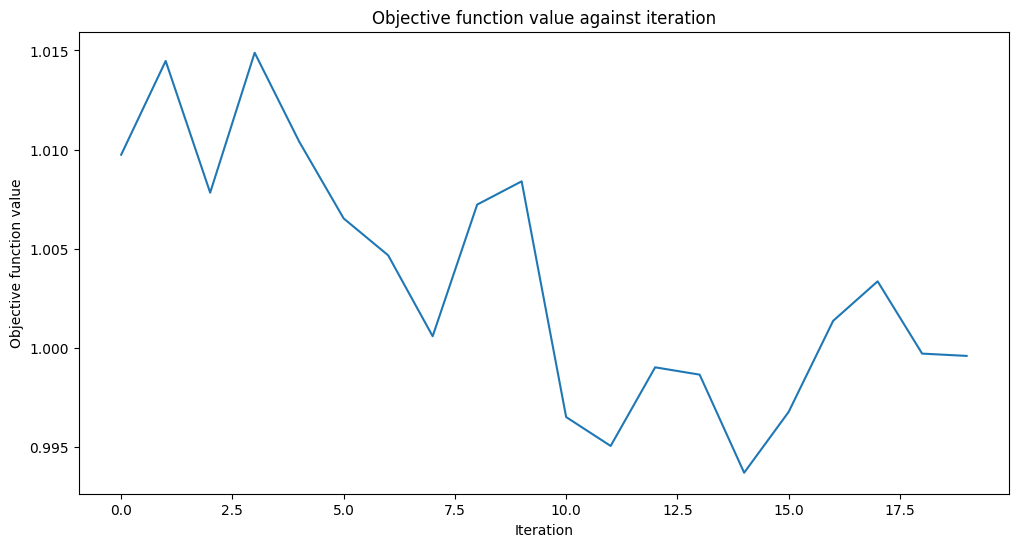

Accuracy from the train data 4 : 53.37%
870.1963539123535


In [41]:
start = time.time()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier4.fit(x, y)

# score classifier
print(f"Accuracy from the train data 4 : {np.round(100 * classifier4.score(x, y), 2)}%")
end = time.time()
print(end - start)
end = 0
start = 0

In [43]:
y_predict4 = classifier4.predict(x_test1)

print(f"Accuracy from the test data 4 : {np.round(100 * classifier4.score(x_test1, y_test1), 2)}%")

Accuracy from the test data 4 : 52.59%


In [44]:
print("Precision: ", precision_score(y_test1, y_predict4).round(3))

print("Recall (sensitivity): ", recall_score(y_test1, y_predict4).round(3))

print("F1 score: ", f1_score(y_test1, y_predict4).round(3))

Precision:  0.513
Recall (sensitivity):  0.513
F1 score:  0.513


In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_predict4)

array([[544, 466],
       [467, 491]])

**ZZ Feature Map**

In [46]:
feature_map = ZZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4,5,6,7], "p1"), list(range(8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(4, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(4, 8)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(6, 8)), inplace=True)

# Fouth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

In [47]:
backend = GenericBackendV2(num_qubits=latent_dim)

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    layout_method="trivial", # Fixed layout mapped in circuit order
)

#pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circ11 = pass_manager.run(circuit)
#transpiled_circ1.barrier()
#transpiled_circ1.measure_all()
# View the transpiled circuit
transpiled_circ11.draw(output='mpl', idle_wires=False)

In [48]:
#observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
observable = SparsePauliOp.from_list([("Z" * circuit.num_qubits, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn11 = EstimatorQNN(
    circuit=transpiled_circ11,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
#with open("11_qcnn_initial_point.json", "r") as f:
#    initial_point = json.load(f)

In [49]:

classifier11 = NeuralNetworkClassifier(
    qnn11,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,# Set max iterations here

)

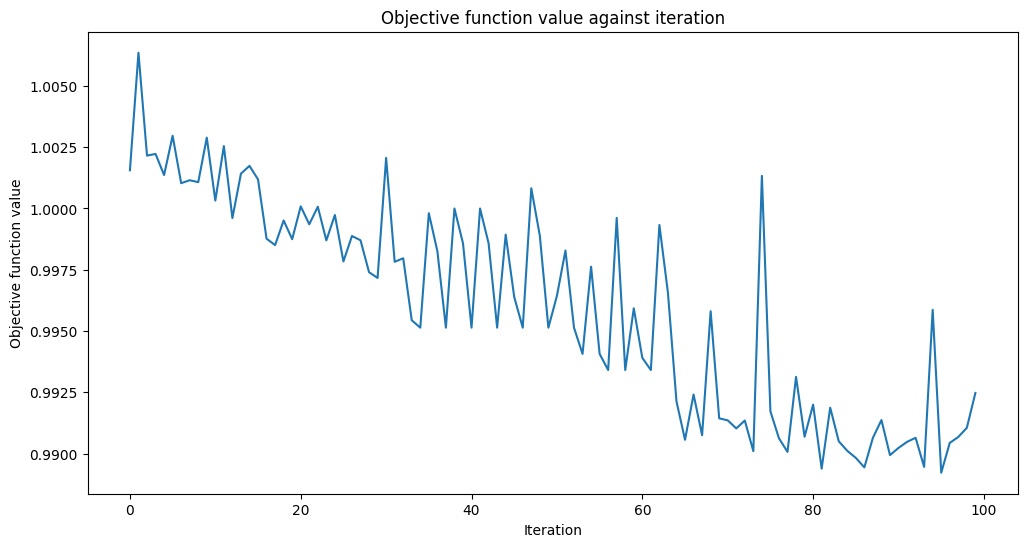

Accuracy from the train data 6 : 52.97%
6690.019229650497


In [50]:
start = time.time()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier11.fit(x, y)

# score classifier
print(f"Accuracy from the train data 6 : {np.round(100 * classifier11.score(x, y), 2)}%")
end = time.time()
print(end - start)
end = 0
start = 0

In [51]:
y_predict11 = classifier11.predict(x_test1)

print(f"Accuracy from the test data 4 : {np.round(100 * classifier11.score(x_test1, y_test1), 2)}%")

Accuracy from the test data 4 : 51.37%


In [52]:
print("Precision: ", precision_score(y_test1, y_predict11, average='weighted').round(3))

print("Recall (sensitivity): ", recall_score(y_test1, y_predict11, average='weighted').round(3))

print("F1 score: ", f1_score(y_test1, y_predict11, average='weighted').round(3))

Precision:  0.514
Recall (sensitivity):  0.514
F1 score:  0.514


In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_predict11)

array([[529, 481],
       [476, 482]])